<a href="https://colab.research.google.com/github/neirezcher/ImageSegmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [4]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=9e6c49451bf095bf23fb4c62ec7494bf0e959e8ec4534eda607fb9c1bb91ef8e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=3ac1197382931359ce4450cc3dffef926eba2b359be08018e920d2d57d089bbf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [5]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.


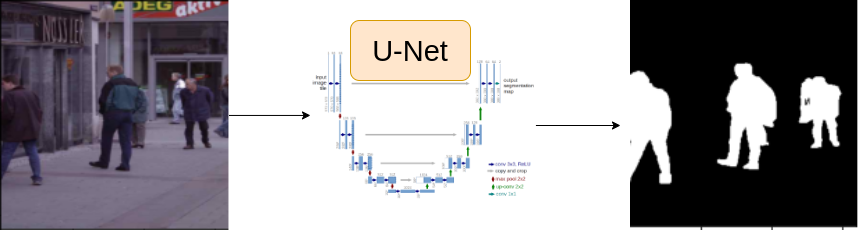

# Some Common Imports

In [6]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [62]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [8]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE= 'cuda'

EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER='time-efficientnet-b0'
WEIGHTS='imagenet'

In [9]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [12]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

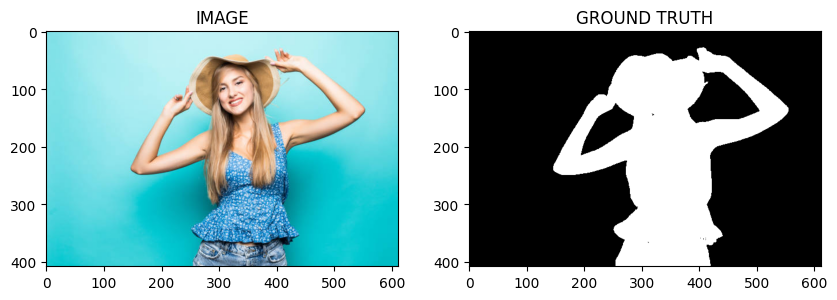

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df= train_test_split(df,test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [26]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations) -> None:
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index) :
    row=self.df.iloc[index]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Check image and mask dimensions before augmentation
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    # If the image and mask sizes are different, resize the mask to match the image
    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        print(f"Resized mask to match image: Mask shape after resize: {mask.shape}")

    mask= np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']

    image= np.transpose(image, (2,0,1)).astype(np.float32)
    mask= np.transpose(mask, (2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)
    return image, mask

In [27]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [28]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


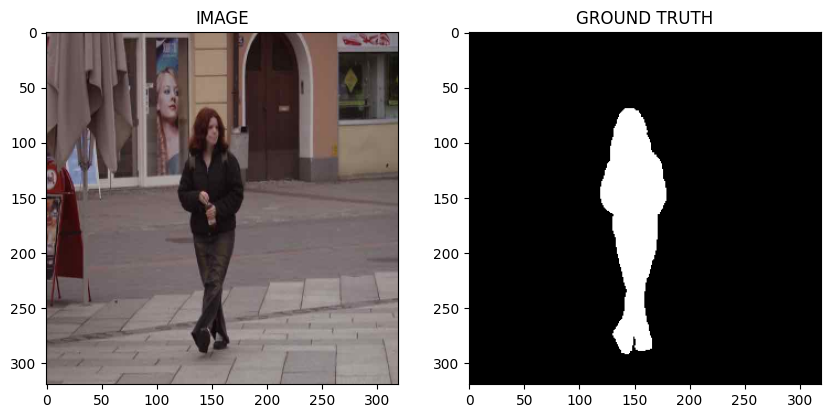

In [31]:
index=15

image, mask= trainset[index]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [33]:
from torch.utils.data import DataLoader

In [34]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)

In [35]:
print(f"total no. of batches in TrainLoader : {len(trainloader)}")
print(f"total no. of batches in ValidLoader : {len(validloader)}")

total no. of batches in TrainLoader : 15
total no. of batches in ValidLoader : 4


In [36]:
for image, mask in trainloader:
  break
print(f"one batch image shape : {image.shape}")
print(f"one batch mask shape : {mask.shape}")

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (162, 311, 3), Mask shape: (162, 311)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (916, 960, 3), Mask shape: (488, 512)
Resized mask to match image: Mask shape after resize: (916, 960)
Image shape: (188, 268, 3), Mask shape: (188, 268)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 276, 3), Mask shape: (183, 276)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask sh

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [37]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [48]:
class SegmentationModel(nn.Module):
    def __init__(self, encoder_name='timm-efficientnet-b0', encoder_weights='imagenet'):
        super(SegmentationModel, self).__init__()

        # Initialize the UNet architecture from segmentation models
        self.arc = smp.Unet(
            encoder_name=encoder_name,       # The encoder you want to use
            encoder_weights=encoder_weights, # Pretrained weights for encoder
            in_channels=3,                   # Input channels (RGB)
            classes=1,                       # Output classes (1 for binary)
            activation=None                  # No activation function for logits
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            # Compute Dice Loss for binary segmentation
            loss1 = DiceLoss(mode='binary')(logits, masks)

            # Compute Binary Cross Entropy Loss
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)

            # Return logits and the combined loss
            return logits, loss1 + loss2

        # Return just the logits if no mask is provided (in inference mode)
        return logits

In [49]:
model= SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 14.0MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [55]:
def train_fn(data_loader, model, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    # Iterate through the data loader
    for images, masks in data_loader:
        # Move images and masks to the appropriate device (GPU/CPU)
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # Zero out gradients from the previous step
        optimizer.zero_grad()

        # Forward pass through the model
        logits, loss = model(images, masks)

        # Backward pass to compute gradients
        loss.backward()

        # Update weights based on computed gradients
        optimizer.step()

        # Accumulate the total loss for monitoring
        total_loss += loss.item()

    # Return the average loss for the epoch
    return total_loss / len(data_loader)

In [56]:
def eval_fn(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_dice_score = 0.0  # You can add other metrics like IoU if needed
    total_batches = len(data_loader)

    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, masks in tqdm(data_loader):
            # Move images and masks to the device (GPU/CPU)
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            # Forward pass through the model (no backprop or optimizer step)
            logits, loss = model(images, masks)

            # Compute total loss
            total_loss += loss.item()

            # Calculate Dice score (or other metric) for evaluation
            dice_score = DiceLoss(mode='binary').forward(logits, masks).item()  # Or use IoU
            total_dice_score += dice_score

    # Compute average loss and average Dice score across all batches
    avg_loss = total_loss / total_batches
    avg_dice_score = total_dice_score / total_batches

    return avg_loss, avg_dice_score

# Task 8 : Train Model

In [52]:
optimizer= torch.optim.Adam(model.parameters(),lr=LR)

In [58]:
best_valid_loss=np.Inf
for epoch in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)

    # Unpack the tuple returned by eval_fn
    valid_loss, valid_dice = eval_fn(validloader, model)

    # Compare the valid_loss (which is a float) with best_valid_loss
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved Model")

    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Dice Score: {valid_dice:.4f}')


Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (360, 640, 3), Mask shape: (360, 640)
Image shape: (646, 970, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (646, 970)
Image shape: (633, 950, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (633, 950)
Image shape: (400, 700, 3), Mask shape: (378, 661)
Resized mask to match image: Mask shape after resize: (400, 700)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:00,  5.65it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.36it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640

100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [1/25]
Train Loss: 0.3666
Valid Loss: 0.5184, Valid Dice Score: 0.1266
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (450, 787, 3), Mask shape: (378, 661)
Resized mask to match image: Mask shape after resize: (450, 787)
Image shape: (159, 318, 3), Mask shape: (159, 318)
Image shape: (480, 852, 3), Mask shape: (375, 666)
Resized mask to match image: Mask shape after resize: (480, 852)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (145, 348, 3), Mask shape: (145, 348)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image s

 25%|██▌       | 1/4 [00:00<00:00,  5.05it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

 75%|███████▌  | 3/4 [00:00<00:00,  4.14it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Saved Model
Epoch [2/25]
Train Loss: 0.2968
Valid Loss: 0.3289, Valid Dice Score: 0.1184
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (458, 307, 3), Mask shape: (458, 307)
Image shape: (1055, 1280, 3), Mask shape: (454, 551)
Resized mask to match image: Mask shape after resize: (1055, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 276, 3), Mask shape: (183, 276)
Image shape: (281, 450, 3), Mask shape: (281, 450)
Image shape: (562, 750, 3), Mask shape: (433, 578)
Resized mask to match image: Mask shape after resize: (562, 750)
Image shape: (541, 1000, 3), Mask shape: (368, 680)
Resized mask to match image: Mask shape after resize: (541, 1000)
Image

 25%|██▌       | 1/4 [00:00<00:00,  5.57it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.38it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Ma

100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [3/25]
Train Loss: 0.2830
Valid Loss: 0.2955, Valid Dice Score: 0.1080
Image shape: (166, 303, 3), Mask shape: (166, 303)
Image shape: (505, 786, 3), Mask shape: (401, 624)
Resized mask to match image: Mask shape after resize: (505, 786)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (639, 1000, 3), Mask shape: (400, 625)
Resized mask to match image: Mask shape after resize: (639, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (4

 25%|██▌       | 1/4 [00:00<00:00,  5.74it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.49it/s]

Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (667, 1000, 3), Mask

 75%|███████▌  | 3/4 [00:00<00:00,  5.29it/s]

Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640

100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [4/25]
Train Loss: 0.2492
Valid Loss: 0.2732, Valid Dice Score: 0.1165
Image shape: (300, 450, 3), Mask shape: (300, 450)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (347, 520, 3), Mask shape: (347, 520)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (1030, 634, 3), Mask shape: (637, 392)
Resize

 25%|██▌       | 1/4 [00:00<00:00,  5.83it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after 

 75%|███████▌  | 3/4 [00:00<00:00,  5.37it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Ma

100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [5/25]
Train Loss: 0.2465
Valid Loss: 0.2612, Valid Dice Score: 0.1048
Image shape: (183, 276, 3), Mask shape: (183, 276)
Image shape: (182, 277, 3), Mask shape: (182, 277)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (195, 259, 3), Mask shape: (195, 259)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (640, 48

 25%|██▌       | 1/4 [00:00<00:00,  5.78it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [6/25]
Train Loss: 0.2200
Valid Loss: 0.1836, Valid Dice Score: 0.0802
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (169, 299, 3), Mask shape: (169, 299)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image s

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask s

 50%|█████     | 2/4 [00:00<00:00,  4.27it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Saved Model
Epoch [7/25]
Train Loss: 0.1778
Valid Loss: 0.2134, Valid Dice Score: 0.0861
Image shape: (960, 1280, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (960, 1280)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (151, 333, 3), Mask shape: (151, 333)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (163, 310, 3), Mask shape: (163, 310)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (180, 280, 3), Mask shape: (180, 280)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized m

 25%|██▌       | 1/4 [00:00<00:00,  5.85it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.38it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [8/25]
Train Loss: 0.1657
Valid Loss: 0.2589, Valid Dice Score: 0.1032
Image shape: (188, 268, 3), Mask shape: (188, 268)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (960, 1280, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (960, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Ima

 25%|██▌       | 1/4 [00:00<00:00,  4.97it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  4.73it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Saved Model
Epoch [9/25]
Train Loss: 0.2127
Valid Loss: 0.2738, Valid Dice Score: 0.1025
Image shape: (204, 247, 3), Mask shape: (204, 247)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (789, 1184, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (789, 1184)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 852, 3), Mask shape: (375, 666)
Resized mask to match image: Mask shape after resize: (480, 852)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized m

 25%|██▌       | 1/4 [00:00<00:00,  5.11it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.09it/s]

Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (4

100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [10/25]
Train Loss: 0.2438
Valid Loss: 0.2223, Valid Dice Score: 0.0948
Image shape: (627, 1200, 3), Mask shape: (361, 692)
Resized mask to match image: Mask shape after resize: (627, 1200)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (400, 700, 3), Mask shape: (378, 661)
Resized mask to match image: Mask shape after resize: (400, 700)
Image shape: (789, 1184, 3), Mask shape: (408, 613)
Resized mask to m

 25%|██▌       | 1/4 [00:00<00:00,  5.83it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.38it/s]

Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (667, 1000, 3), Mask

 75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [11/25]
Train Loss: 0.2085
Valid Loss: 0.2930, Valid Dice Score: 0.0872
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (188, 268, 3), Mask shape: (188, 268)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resize

 25%|██▌       | 1/4 [00:00<00:00,  5.86it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.53it/s]

Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after 

 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Ma

100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [12/25]
Train Loss: 0.1974
Valid Loss: 0.2369, Valid Dice Score: 0.0862
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resi

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:00,  4.99it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask s

 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)

100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Resized mask to match image: Mask shape after resize: (480, 640)


Saved Model
Epoch [13/25]
Train Loss: 0.1929
Valid Loss: 0.2066, Valid Dice Score: 0.0799
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 450, 3), Mask shape: (300, 450)
Image shape: (408, 612, 3), Mask shape: (408, 612)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shap

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:01,  2.76it/s]

Image shape: (503, 805, 3), Mask shape: (395, 633)
Resized mask to match image: Mask shape after resize: (503, 805)
Image shape: (164, 308, 3), Mask shape: (164, 308)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  2.52it/s]

Image shape: (225, 225, 3), Mask shape: (225, 225)
Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Ma

 75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


Saved Model
Epoch [14/25]
Train Loss: 0.1407
Valid Loss: 0.1886, Valid Dice Score: 0.0801
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (204, 247, 3), Mask shape: (204, 247)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (180, 280, 3), Mask shape: (180, 280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 6

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask s

 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Saved Model
Epoch [15/25]
Train Loss: 0.1502
Valid Loss: 0.1842, Valid Dice Score: 0.0737
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (150, 335, 3), Mask shape: (150, 335)
Image shape: (790, 1186, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (790, 1186)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (408, 612, 3), Mask shape: (408, 612)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized 

 25%|██▌       | 1/4 [00:00<00:00,  5.49it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.33it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.29it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [16/25]
Train Loss: 0.1221
Valid Loss: 0.2026, Valid Dice Score: 0.0788
Image shape: (182, 277, 3), Mask shape: (182, 277)
Image shape: (1024, 683, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (1024, 683)
Image shape: (789, 1184, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (789, 1184)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize:

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

Image shape: (164, 308, 3), Mask shape: (164, 308)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  2.61it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

 75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


Saved Model
Epoch [17/25]
Train Loss: 0.1275
Valid Loss: 0.1829, Valid Dice Score: 0.0699
Image shape: (198, 255, 3), Mask shape: (198, 255)
Image shape: (467, 830, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (467, 830)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (408, 612, 3), Mask shape: (408, 612)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (639, 1000, 3), Mask shape: (400, 625)
Resized mask to match image: Mask shape after resize: (639, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized 

 25%|██▌       | 1/4 [00:00<00:00,  5.72it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.33it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.29it/s]

Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to m

100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [18/25]
Train Loss: 0.1340
Valid Loss: 0.2154, Valid Dice Score: 0.0872
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (916, 960, 3), Mask shape: (488, 512)
Resized mask to match image: Mask shape after resize: (916, 960)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resize

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask s

 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [19/25]
Train Loss: 0.1345
Valid Loss: 0.3375, Valid Dice Score: 0.1236
Image 

 25%|██▌       | 1/4 [00:00<00:00,  5.64it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.22it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640

100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [20/25]
Train Loss: 0.1686
Valid Loss: 0.2259, Valid Dice Score: 0.0857
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (166, 303, 3), Mask shape: (166, 303)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to matc

 25%|██▌       | 1/4 [00:00<00:00,  5.77it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.16it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [21/25]
Train Loss: 0.1259
Valid Loss: 0.1908, Valid Dice Score: 0.0654
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (400, 700, 3), Mask shape: (378, 661)
Resized mask to match image: Mask shape after resize: (400, 700)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (48

 25%|██▌       | 1/4 [00:00<00:00,  5.27it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  4.28it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

 75%|███████▌  | 3/4 [00:00<00:00,  4.07it/s]

Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Saved Model
Epoch [22/25]
Train Loss: 0.1173
Valid Loss: 0.1750, Valid Dice Score: 0.0672
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (275, 183, 3), Mask shape: (275, 183)
Image shape: (427, 640, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (427, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (182, 277, 3), Mask shape: (182, 277)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (793, 1200, 3), Mask shape: (406, 615)
Resized m

  0%|          | 0/4 [00:00<?, ?it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 25%|██▌       | 1/4 [00:00<00:00,  3.53it/s]

Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (243, 365, 3), Mask shape: (243, 365)
Image shape: (189, 267, 3), Mask shape: (189, 267)
Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask s

 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

Image shape: (667, 1000, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (667, 1000)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480

100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Image shape: (201, 251, 3), Mask shape: (201, 251)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (300, 300, 3), Mask shape: (300, 300)
Image shape: (169, 298, 3), Mask shape: (169, 298)
Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [23/25]
Train Loss: 0.1012
Valid Loss: 0.1877, Valid Dice Score: 0.0646
Image 

 25%|██▌       | 1/4 [00:00<00:00,  5.72it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (480, 640)
Image shape: (168, 299, 3), Mask shape: (168, 299)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (225, 225, 3), Mask 

 75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (240, 480, 3), Mask shape: (240, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (201

100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Saved Model
Epoch [24/25]
Train Loss: 0.0923
Valid Loss: 0.1794, Valid Dice Score: 0.0664
Image shape: (163, 310, 3), Mask shape: (163, 310)
Image shape: (427, 640, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (427, 640)
Image shape: (633, 950, 3), Mask shape: (408, 613)
Resized mask to match image: Mask shape after resize: (633, 950)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resize

 25%|██▌       | 1/4 [00:00<00:00,  5.33it/s]

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (200, 300, 3), Mask shape: (200, 300)
Image shape: (168, 300, 3), Mask shape: (168, 300)
Image shape: (288, 416, 3), Mask shape: (288, 416)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (183, 275, 3), Mask shape: (183, 275)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (440, 660, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (440, 660)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after res

 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

Image shape: (938, 626, 3), Mask shape: (612, 408)
Resized mask to match image: Mask shape after resize: (938, 626)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (600, 900, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (600, 900)
Image shape: (388, 583, 3), Mask shape: (388, 583)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (500, 750, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (500, 750)
Image shape: (720, 1280, 3), Mask shape: (375, 667)
Resized mask to match image: Mask shape after resize: (720, 1280)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 

 75%|███████▌  | 3/4 [00:00<00:00,  4.73it/s]

Image shape: (535, 1020, 3), Mask shape: (362, 690)
Resized mask to match image: Mask shape after resize: (535, 1020)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (251, 201, 3), Mask shape: (251, 201)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (640, 480, 3), Mask shape: (577, 433)
Resized mask to match image: Mask shape after resize: (640, 480)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)
Image shape: (1498, 1000, 3), Mask shape: (612, 409)
Resized mask to match image: Mask shape after resize: (1498, 1000)
Image shape: (4

100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

Image shape: (1001, 1500, 3), Mask shape: (408, 612)
Resized mask to match image: Mask shape after resize: (1001, 1500)
Image shape: (288, 360, 3), Mask shape: (288, 360)
Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


Saved Model
Epoch [25/25]
Train Loss: 0.0868
Valid Loss: 0.1736, Valid Dice Score: 0.0637


# Task 9 : Inference

In [64]:
idx=50
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

Image shape: (480, 640, 3), Mask shape: (433, 577)
Resized mask to match image: Mask shape after resize: (480, 640)


<ipython-input-64-05f20a74028d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


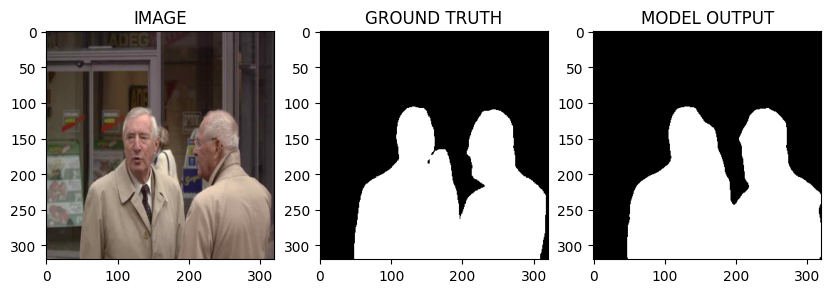

In [65]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))